In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_notStemmed_withoutRT.csv"
# make this point to the file with the text tweets
TWEETSFILE = "data_original_notStemmed_withoutRT.csv"
# this points to the csv with the sentiments
SENTIMENTCSV = "Data/sentiment_lexicons.csv"

In [2]:
# import the tweets
text_tweets = pandas.read_csv(TWEETSFILE, index_col=0)
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))
    
# find all unique words and count them
uniqueWords = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in uniqueWords.keys():
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
print(f"We have {total_words} words, of which {len(uniqueWords.keys())} are unique")
words_tuples = [(word, uniqueWords[word]) for word in uniqueWords.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])
print(words_tuples[0:10])

We have 53305 words, of which 6661 are unique
[('great', 826), ('people', 432), ('country', 324), ('u', 292), ('trump', 287), ('president', 283), ('democrats', 272), ('many', 269), ('big', 257), ('border', 253)]


In [34]:
def explore_clusters(cluster_list, callback=None):
    """Explores the list of clusters provided"""
    # callback is some additional function that gives information about each cluster
    # for example, printing the center of each cluster
    for k, cluster in enumerate(cluster_list):
        tweets_in_cluster = []
        for tweet in data["text"][cluster]:
            tweets_in_cluster.append(eval(tweet))
        # get the unique set of existing words and count those words
        # check the most common ones
        words = {}
        total_words = 0
        for tweet in tweets_in_cluster:
            for word in tweet:
                total_words += 1
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
        print(f"We have {total_words} words, of which {len(words.keys())} are unique")
        words_tuples = [(word, words[word]) for word in words.keys()]
        words_tuples.sort(reverse=True, key=lambda t: t[1])

        # plot a histogram of the N most common words
        fig, ax = plt.subplots(figsize=(9,7))
        N = 15
        heights = [tup[1] for tup in words_tuples[:N]]
        words = [tup[0] for tup in words_tuples[:N]]
        indices = list(range(1, 3*N+1, 3))
        bar_width = 2

        ax.barh(indices, heights, bar_width)
        ax.set_yticks(indices)
        ax.set_yticklabels(words)
        ax.set_title(f"Most common tweet words in cluster {k}")
        
        if callback:
            callback(k)

        some_tweet_idx = random.sample(cluster, 5)
        for idx in some_tweet_idx:
            print(str(idx) + " - " + (text_tweets["text"][idx]))
        print("-"*40)

In [3]:
# import the sentiments and set up their categories
# based on https://github.com/beefoo/text-analysis
sentiment_lexicons = pandas.read_csv(SENTIMENTCSV)
# keep only the words that we will eventually need
sentiment_lexicons = sentiment_lexicons[sentiment_lexicons.word.map(lambda x: x in uniqueWords.keys())]
sentiment_lexicons = sentiment_lexicons.drop(columns=["source"])

categories = {
  "emotion": ["anger", "fear", "anticipation", "trust", "surprise", "sadness", "joy", "disgust"],
  "subjectivity": ["weak", "strong"],
  "sentiment": ["positive", "negative"],
  "orientation": ["active", "passive"],
  "color": ["white", "black", "red", "green", "yellow", "blue", "brown", "pink", "purple", "orange", "grey"]
}

print(sentiment_lexicons[:10])

          word       emotion  color orientation sentiment subjectivity
5      abandon          fear    NaN         NaN  negative         weak
6    abandoned         anger  black         NaN  negative         weak
28     ability           NaN    NaN         NaN  positive         weak
33        able           NaN    NaN         NaN  positive         weak
37     abolish         anger    NaN      active  negative         weak
60    abruptly           NaN    red         NaN  negative          NaN
69    absolute           NaN    NaN         NaN  positive       strong
70  absolutely           NaN    NaN         NaN       NaN       strong
80   abundance  anticipation  green         NaN  negative         weak
82       abuse         anger  black      active  negative         weak


In [4]:
# we will cluster by emotion now
# if <categories> has E emotions, each tweet will be a vector v of length E
# for i < E, v[i] = {# of words associated with emotion categories["emotion"][i]}
mat = []
# at the cost of some temporary memory, make this processing faster
# cache[word] = i, if the word correspondes to the coordinate i of the vector,
# as per the comment above; cache[word] = -1 if the word has been processed BUT
# corresponds to no emotion
cache = {}
emotions = categories["emotion"]
E = len(emotions)
for tweet in tweets:
    vec = [0 for i in range(E)]
    for word in tweet:
        idx = cache.get(word, None)
        if idx is not None and idx > -1:
            vec[idx] += 1
        else:
            # is this word in our lexicon data base?
            p = sentiment_lexicons.loc[word == sentiment_lexicons.word]
            if len(p) == 0:
                cache[word] = -1
            else:
                emot = p.loc[p.index[0], "emotion"]
                idx = -1 if emot not in emotions else emotions.index(emot)
                cache[word] = idx
                if idx > -1:
                    vec[cache[word]] += 1
    mat.append(vec)

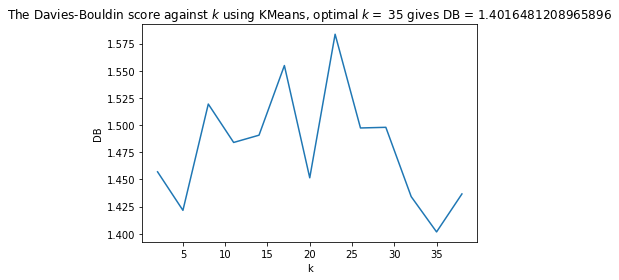

In [42]:
# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters = k, random_state=13032019).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Bouldin score against $k$ using KMeans, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()

[1132, 494, 306, 437, 666]
We have 12967 words, of which 3244 are unique
[('anticipation', 0.30035335689045406), ('trust', 0.3003533568904472), ('joy', 0.16696113074204844), ('fear', 0.1660777385158994), ('sadness', 0.1148409893992926), ('anger', 0.08038869257948478), ('surprise', 0.07155477031802197), ('disgust', 0.05035335689045801)]
502 - Landing in Montana now - at least everybody admits that my lines and crowds are far bigger than Barack Obama’s... https://t.co/PCibGjS209
1255 - https://t.co/3PAVDdfJJr
804 - https://t.co/k2bOxapRtR
1672 - Joint Press Conference from Helsinki, Finland: https://t.co/fadLMDuGiY
771 - PROMISES MADE, PROMISES KEPT! https://t.co/2lk8Fjspe4
----------------------------------------
We have 10366 words, of which 2948 are unique
[('trust', 2.578947368421037), ('anticipation', 0.7732793522267205), ('anger', 0.548582995951419), ('fear', 0.34412955465587086), ('joy', 0.28340080971659953), ('surprise', 0.20040485829959565), ('sadness', 0.14574898785425103), ('d

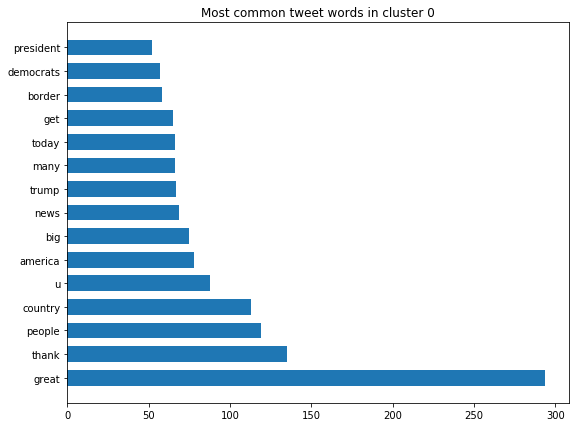

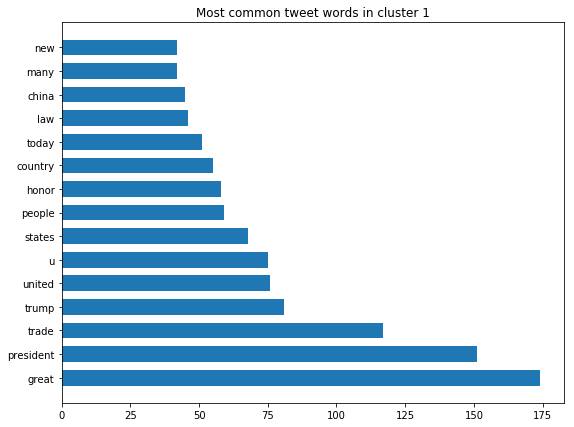

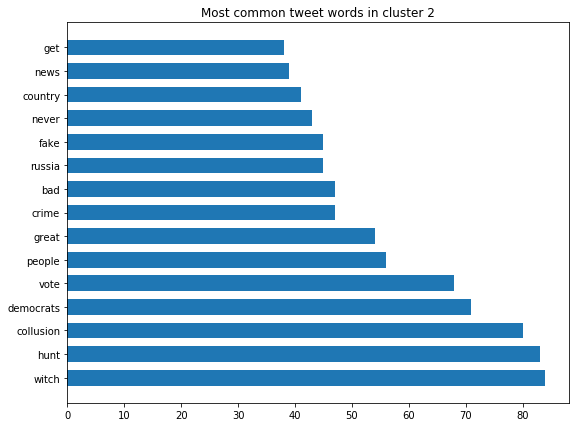

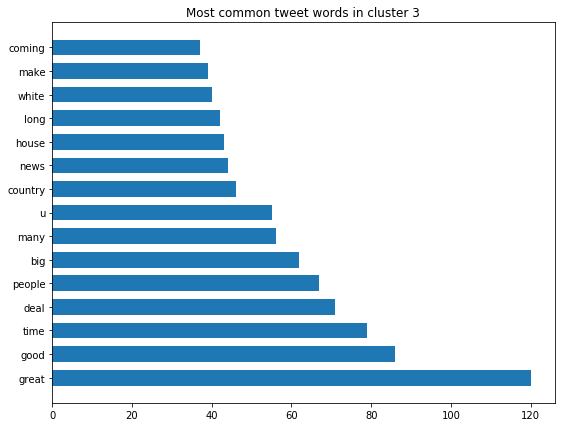

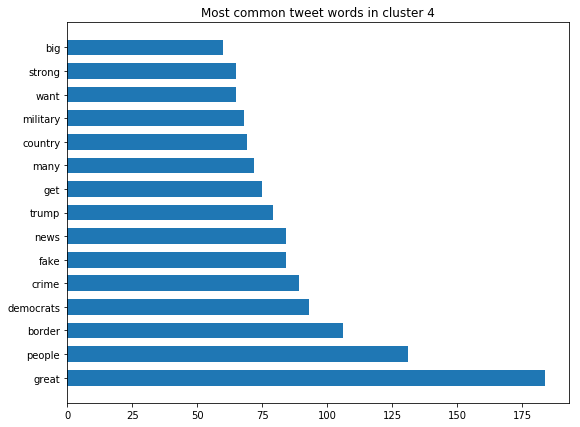

In [37]:
# apply the KMeans algorithm to the data,
# even though 35 gave the smallest DB, stick with 5 because that is
# 7x smaller
kmeans = KMeans(5, random_state=10032019).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))

def callback(k):
    center = kmeans.cluster_centers_[k]
    # order the emotions by most present to least present
    orders = [(emotions[i], center[i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)

random.seed(112233)
# take some random tweets from every cluster
explore_clusters(sk_clusters, callback)

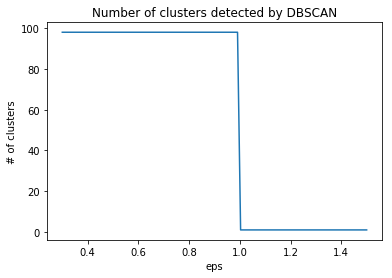

In [21]:
# apply the DBSCAN algorithm to the data for different values of K
Eps = np.linspace(.3,1.5,100)
DB = np.zeros_like(Eps).astype(float)
nclusters = []
for i, eps in enumerate(Eps):
    dbscan = DBSCAN(eps = eps).fit(mat)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    nclusters.append(len(dbscan_clusters))
    
plt.plot(Eps, nclusters)
plt.title("Number of clusters detected by DBSCAN")
plt.xlabel("eps")
plt.ylabel("# of clusters")
plt.show()

Using eps = 0.3 , got 7 clusters
Using eps = 0.3631578947368421 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.4263157894736842 , got 7 clusters
Using eps = 0.4894736842105263 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.5526315789473684 , got 7 clusters
Using eps = 0.6157894736842104 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.6789473684210526 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.7421052631578948 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.8052631578947369 , got 7 clusters
Using eps = 0.868421052631579 , got 7 clusters

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances



Using eps = 0.9315789473684211 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.9947368421052631 , got 7 clusters


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 1.0578947368421052 , got 1 clusters
Using eps = 1.1210526315789473 , got 1 clusters
Using eps = 1.1842105263157896 , got 1 clusters
Using eps = 1.2473684210526317 , got 1 clusters
Using eps = 1.3105263157894738 , got 1 clusters
Using eps = 1.3736842105263158 , got 1 clusters
Using eps = 1.436842105263158 , got 1 clusters
Using eps = 1.5 , got 1 clusters


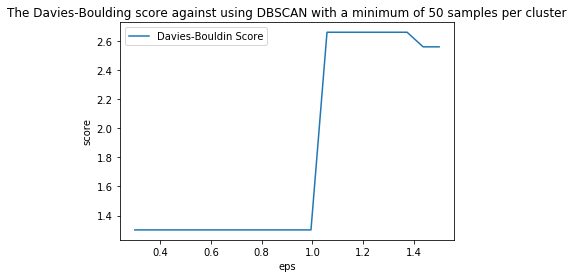

In [43]:
# apply the DBSCAN algorithm to the data for different values of K
# FIX THE ARGUMENT MIN_SAMPLES
Eps = np.linspace(.3,1.5,20)
DB = np.zeros_like(Eps).astype(float)
for i, eps in enumerate(Eps):
    dbscan = DBSCAN(eps = eps, min_samples=50).fit(mat)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    print(f"Using eps = {eps} , got {len(dbscan_clusters)} clusters")

    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, dbscan.labels_)
        
plt.plot(Eps, DB, label = 'Davies-Bouldin Score')
plt.xlabel('eps')
plt.ylabel('score')
plt.title(r'The Davies-Boulding score against using DBSCAN with a minimum of 50 samples per cluster')
plt.legend()
plt.show()

[52, 112, 351, 124, 59, 81, 2256]
We have 462 words, of which 315 are unique
[('anger', 4.520325203252033), ('trust', 1.0731707317073171), ('anticipation', 0.5934959349593496), ('fear', 0.44715447154471544), ('joy', 0.21951219512195122), ('surprise', 0.17073170731707318), ('sadness', 0.13008130081300814), ('disgust', 0.13008130081300814)]
200 - ....I am thankful to both of these incredible men for their service to our Country! Date of transition to be determined.
1479 - Thank you Pennsylvania. I love you! https://t.co/qoswnBZb3f
254 - We would save Billions of Dollars if the Democrats would give us the votes to build the Wall. Either way, people will NOT be allowed into our Country illegally! We will close the entire Southern Border if necessary. Also, STOP THE DRUGS!
674 - Beautiful evening in Mesa, Arizona with GREAT PATRIOTS - thank you! https://t.co/0pWiwCq4MH #MAGARally????replay: https://t.co/6vHEaB37VH https://t.co/pHmU6pMKh7
815 - Thank you Kansas - I love you! 
https://t.co/ym

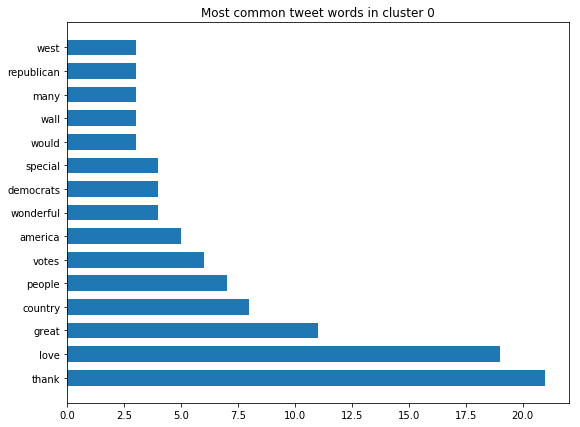

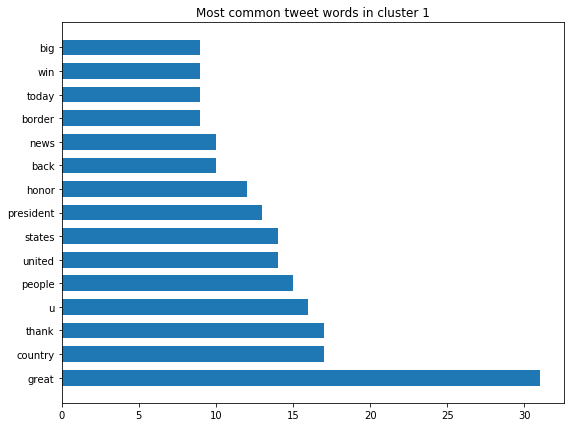

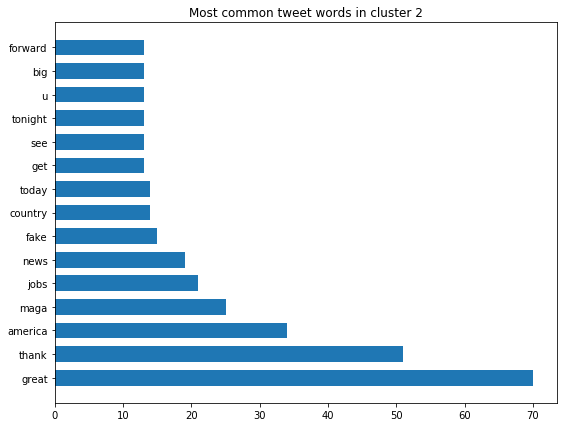

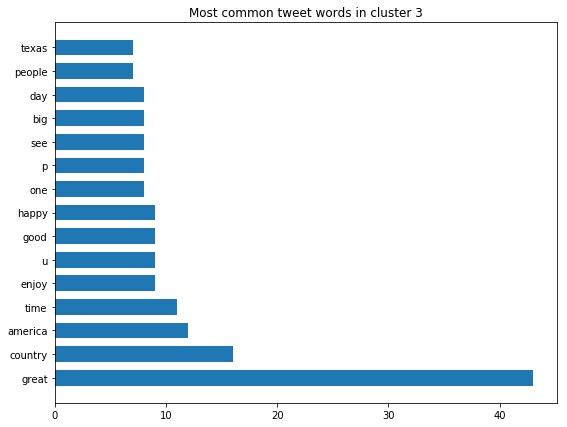

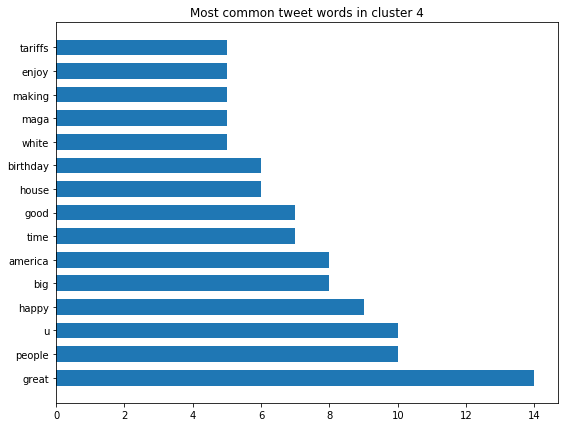

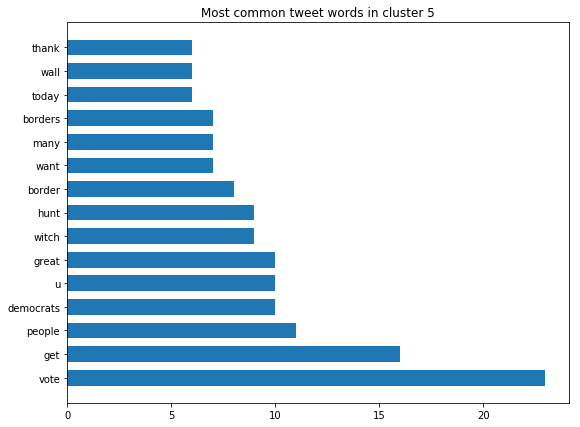

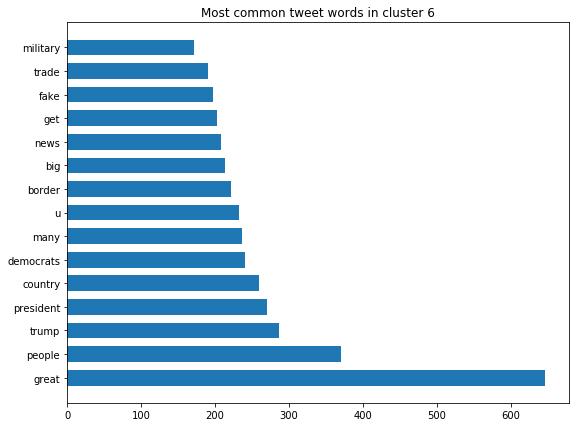

In [38]:
# apply the DBSCAN algorithm to the data
dbscan = DBSCAN(eps=0.9, min_samples=50).fit(mat)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)

print(list(map(len, dbscan_clusters)))

def callback(k):
    # find the "center" of this cluster
    acc = np.zeros([1, E])
    for idx in cluster:
        acc += np.array(mat[idx], float)
    center = acc/len(cluster)
    # order the emotions by most present to least present
    orders = [(emotions[i], center[0, i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)

random.seed(1653)
explore_clusters(dbscan_clusters, callback)

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_dista

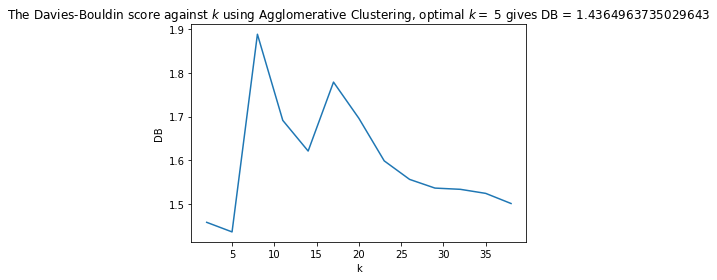

In [44]:
# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    agg = AgglomerativeClustering(n_clusters=k).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, agg.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'The Davies-Bouldin score against $k$ using Agglomerative Clustering, optimal $k = $ {k_opt} gives DB = {np.min(DB)}')
plt.show()

[574, 1420, 465, 453, 123]
We have 12576 words, of which 3282 are unique
[('anger', 4.520325203252033), ('trust', 1.0731707317073171), ('anticipation', 0.5934959349593496), ('fear', 0.44715447154471544), ('joy', 0.21951219512195122), ('surprise', 0.17073170731707318), ('sadness', 0.13008130081300814), ('disgust', 0.13008130081300814)]
1595 - I’m very concerned that Russia will be fighting very hard to have an impact on the upcoming Election. Based on the fact that no President has been tougher on Russia than me, they will be pushing very hard for the Democrats. They definitely don’t want Trump!
2205 - For the first time since Roe v. Wade, America has a Pro-Life President, a Pro-Life Vice President, a Pro-Life House of Representatives and 25 Pro-Life Republican State Capitals! https://t.co/EfF54tmetT
1728 - I have long heard that the most important decision a U.S. President can make is the selection of a Supreme Court Justice - Will be announced tonight at 9:00 P.M.
2700 - Looking forwa

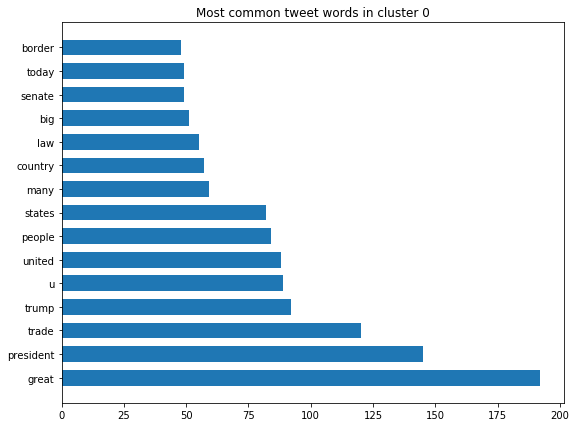

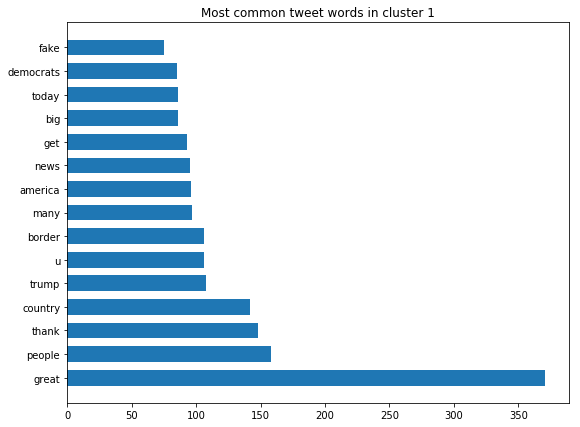

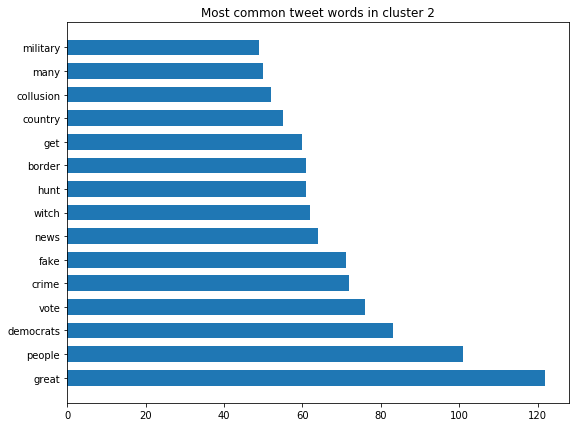

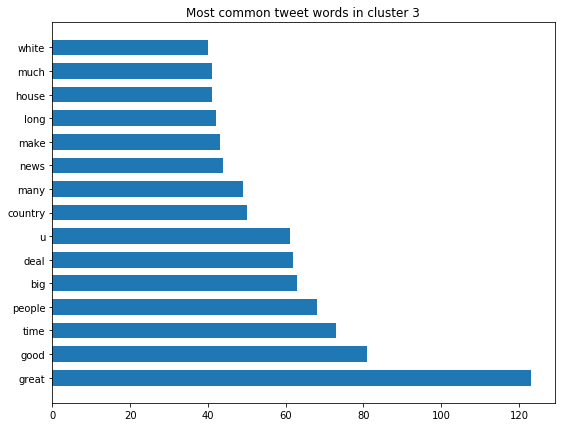

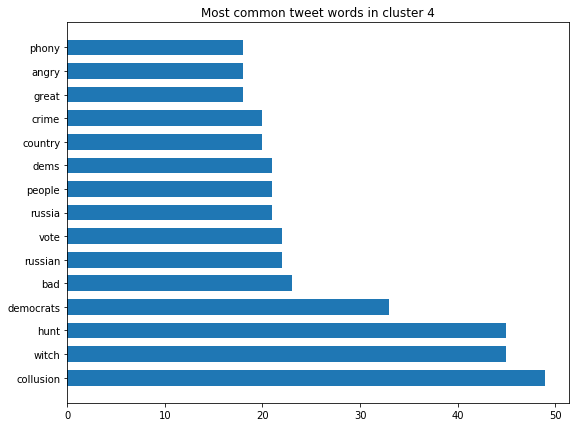

In [41]:
# apply agglomerative clustering
agg = AgglomerativeClustering(n_clusters=5).fit(mat)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

def callback(k):
    # find the "center" of this cluster
    acc = np.zeros([1, E])
    for idx in cluster:
        acc += np.array(mat[idx], float)
    center = acc/len(cluster)
    # order the emotions by most present to least present
    orders = [(emotions[i], center[0, i]) for i in range(len(emotions))]
    orders.sort(key=lambda t: t[1], reverse=True)
    print(orders)

random.seed(162323)
# explore every cluster
explore_clusters(agg_clusters, callback)